## This notebook is for sample to start xgboost experimentation

In [66]:
# Call the required libraries
import pandas as pd
import os
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [3]:
# Prepare the data to test challenge metric
# Define paths
path_to_dataset = './data/'
# Read the training data
train = pd.read_csv(os.path.join(path_to_dataset,'train_data.csv'))
test = pd.read_csv(os.path.join(path_to_dataset,'test_data.csv'))
# Shapes of the train and test dataset
print("shape of train data {}".format(train.shape))
print("shape of test data {}".format(test.shape))

shape of train data (162634, 103)
shape of test data (24484, 103)


In [4]:
# Train time to close approach (TCA) min and max
train["time_to_tca"].describe().loc[["min","max"]]

min   -0.149808
max    6.993832
Name: time_to_tca, dtype: float64

In [5]:
# Train time to close approach min and max
test["time_to_tca"].describe().loc[["min","max"]]

min    2.000213
max    6.993169
Name: time_to_tca, dtype: float64

In [6]:
# Shows how many events exist in the datasets
print("number of events that has less than 1.0 days data : ",len(train[train["time_to_tca"]<1.0].groupby("event_id").count()["time_to_tca"].tolist()))
print("number of events that has more than 2.0 days data : ",len(train[train["time_to_tca"]>2.0].groupby("event_id").count()["time_to_tca"].tolist()))
print("total number of events : ",len(train.groupby("event_id").count()["time_to_tca"].tolist()))
events_less_than_two_days = train[train["time_to_tca"]<1.0].groupby("event_id")["event_id"].first().tolist()
events_more_than_two_days = train[train["time_to_tca"]>2.0].groupby("event_id")["event_id"].first().tolist()

number of events that has less than 1.0 days data :  9463
number of events that has more than 2.0 days data :  11942
total number of events :  13154


In [7]:
# Number of events that has time_to_tca larger and smaller than 2 at the same time
events_trainable = [value for value in events_less_than_two_days if value in events_more_than_two_days]
print("number of trainable events : ",len(events_trainable))

number of trainable events :  8293


In [8]:
# Shows an event
train[train['event_id']==events_trainable[2]]

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
50         4     4.966244          19  -7.870632          -6.800245   
51         4     4.030424          19  -7.968592          -6.807711   
52         4     3.066467          19 -30.000000          -7.661743   
53         4     1.797727          19 -30.000000          -8.792366   
54         4     1.528456          19 -30.000000          -8.795880   
55         4     1.258629          19 -30.000000          -8.763967   
56         4     0.973420          19 -30.000000          -8.759451   
57         4     0.592587          19 -30.000000          -8.764977   
58         4     0.273166          19 -27.650917          -7.819587   

    max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
50          5.111282        31612.0         12093.0                182.4   
51          5.363402        33272.0         12093.0                178.7   
52        434.669432        33593.0         12093.0                163.6   
53       4334.538505        23709.0         12093.0                188.2   
54       4380.345259        23700.0         12093.0                187.7   
55       4022.819178        23099.0         12093.0                182.4   
56       4008.467679        23059.0         12093.0                186.3   
57       4053.221837        23066.0         12093.0                187.1   
58         50.584357        23080.0         12093.0                187.1   

    relative_position_t  ...  t_sigma_rdot  c_sigma_rdot  t_sigma_tdot  \
50             -18561.7  ...      0.315782     23.566497      0.008778   
51             -19540.0  ...      0.216134     22.984521      0.007798   
52             -19727.8  ...      0.081852      2.058484      0.007439   
53             -13921.3  ...      0.049963      1.671888      0.005886   
54             -13915.3  ...      0.038328      1.671888      0.005448   
55             -13563.3  ...      0.038758      1.683556      0.005448   
56             -13540.0  ...      0.037867      1.683555      0.005102   
57             -13545.2  ...      0.023785      1.683555      0.004298   
58             -13552.1  ...      0.024574      4.373659      0.004242   

    c_sigma_tdot  t_sigma_ndot  c_sigma_ndot   F10   F3M   SSN    AP  
50      0.062139      0.005695      0.078138  87.0  86.0  29.0  20.0  
51      0.061950      0.005318      0.078065  85.0  86.0  26.0  35.0  
52      0.054042      0.005327      0.076470  84.0  86.0  30.0  36.0  
53      0.331101      0.005107      0.303638  82.0  86.0  17.0  36.0  
54      0.331101      0.005037      0.303638  82.0  86.0  17.0  36.0  
55      0.331079      0.005038      0.303620  80.0  86.0  12.0  20.0  
56      0.331080      0.007247      0.303619  80.0  86.0  12.0  20.0  
57      0.331080      0.006655      0.303619  80.0  86.0  12.0  20.0  
58      0.331474      0.006524      0.303632  81.0  86.0   0.0  17.0  

[9 rows x 103 columns]

In [9]:
# Generates new training data that uses last available CDM (until 2 days to tca) and \
# adds latest CDM risk as target variable
lenData = len(events_trainable)
new_train = []
target_variable = []
no_larger_2 = []
mean_larger_2 =[]
std_larger_2 = []
mean_nan_number =[]
std_nan_number = []
for cnt in range(lenData):
    new_train.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)][-1:].values.tolist()[0])
    target_variable.append(train[(train["event_id"]==events_trainable[cnt])][-1:].risk.values[0])
    no_larger_2.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].shape[0])
    mean_larger_2.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].risk.mean())
    std_larger_2.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].risk.std(ddof=0))
    mean_nan_number.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].isnull().sum(axis=1).mean())
    std_nan_number.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].isnull().sum(axis=1).std(ddof=0))
new_traintrain_pd = pd.DataFrame(new_train,columns=train.columns.tolist())
# Adds target value to the dataset
target_variable_pd = pd.DataFrame(target_variable,columns=["target_risk"])
no_larger_2_pd = pd.DataFrame(no_larger_2,columns=["no_larger_2"])
mean_larger_2_pd = pd.DataFrame(mean_larger_2,columns=["mean_larger_2"])
std_larger_2_pd = pd.DataFrame(std_larger_2,columns=["std_larger_2"])
mean_nan_number_pd = pd.DataFrame(mean_nan_number,columns=["mean_nan_number"])
std_nan_number_pd = pd.DataFrame(std_nan_number,columns=["std_nan_number"])
new_traintrain_pd["target_risk"] = target_variable_pd.values
new_traintrain_pd["no_larger_2"] = no_larger_2_pd.values
new_traintrain_pd["mean_larger_2"] = mean_larger_2_pd.values
new_traintrain_pd["std_larger_2"] = std_larger_2_pd.values
new_traintrain_pd["mean_nan_number"] = mean_nan_number_pd.values
new_traintrain_pd["std_nan_number"] = std_nan_number_pd.values
new_traintrain_pd.head(20)

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
0          2     2.340627           2 -30.000000          -6.266241   
1          3     2.278941          19 -30.000000          -7.320481   
2          4     3.066467          19 -30.000000          -7.661743   
3          5     2.103772           5 -13.100070          -4.878440   
4          6     2.040187           1 -30.000000          -5.079355   
5          7     2.531723          15 -30.000000          -7.270268   
6          8     2.285275           4 -18.845576          -6.102813   
7          9     2.033839          19 -14.593460          -7.052125   
8         10     2.131981           7 -30.000000          -6.710411   
9         12     2.225275           5 -15.532096          -6.031657   
10        13     2.164909           5 -30.000000          -6.327071   
11        14     2.022985          19 -30.000000          -8.410162   
12        15     2.488965          15 -28.211832          -6.019769   
13        16     2.142430           1  -5.633390          -5.614394   
14        17     2.059816           1 -30.000000          -4.257118   
15        19     2.453022           7 -30.000000          -6.642065   
16        20     2.117526           2  -9.853872          -5.052272   
17        21     2.041105           3 -30.000000          -5.145512   
18        22     2.218107           6 -30.000000          -7.308123   
19        27     2.367779           1 -30.000000          -4.923724   

    max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0       4.014425e+02        18763.0         14347.0               -692.9   
1       1.400012e+02        23900.0         13574.0                 26.3   
2       4.346694e+02        33593.0         12093.0                163.6   
3       2.306854e+01          304.0          2001.0                -13.8   
4       5.542897e+02        10864.0         10027.0                139.5   
5       5.825374e+02        27554.0         12410.0               -708.3   
6       3.386281e+01         4598.0         12218.0                340.3   
7       2.142250e+01        29864.0         14072.0                 81.8   
8       6.675301e+03        35814.0         10813.0               -975.6   
9       1.110749e-10          950.0         13701.0                397.5   
10      3.447598e+02         1709.0         15017.0                -50.5   
11      1.959473e+02        23850.0         10429.0                 69.1   
12      5.631299e+01          524.0         14927.0               -485.4   
13      1.316779e+00        34300.0          8743.0               -328.1   
14      1.061921e+02          559.0         11926.0               -250.9   
15      5.889479e+02        11506.0         11871.0              -1379.4   
16      1.478243e+01         9174.0          7364.0                 46.5   
17      9.582926e+01          348.0         14713.0               -310.9   
18      6.195951e+02        17695.0         14598.0                669.0   
19      1.074749e+02         4195.0          6371.0                392.5   

    relative_position_t  ...    F10    F3M    SSN    AP  target_risk  \
0               -5175.6  ...   69.0   77.0   11.0   6.0   -30.000000   
1               10072.2  ...   68.0   70.0    0.0   7.0   -30.000000   
2              -19727.8  ...   84.0   86.0   30.0  36.0   -27.650917   
3                -301.3  ...   70.0   77.0   11.0   5.0   -30.000000   
4               -8143.1  ...   72.0   70.0   14.0   4.0   -30.000000   
5              -15402.9  ...  122.0  129.0   54.0  11.0   -30.000000   
6                2619.0  ...   71.0   71.0    0.0   9.0   -18.693361   
7              -10132.7  ...   80.0   76.0   25.0   2.0   -14.544394   
8               25210.4  ...   70.0   70.0    0.0   7.0   -30.000000   
9                 359.1  ...    NaN    NaN    NaN   NaN   -30.000000   
10                135.0  ...    NaN    NaN    NaN   NaN   -30.000000   
11              17074.7  ...   70.0   70.0    0.0  

## Note that no_larger_2, mean_larger_2, std_larger_2, mean_nan_number, std_nan_number are all introduced for additional feature derived by aggregating from time-series.

In [10]:
# Shows the ratio betwen high and low risk as percentage 
new_traintrain_pd['target_risk_class']=np.nan
new_traintrain_pd.loc[new_traintrain_pd['target_risk']>=-6.0,'target_risk_class'] = int(1)
new_traintrain_pd.loc[new_traintrain_pd['target_risk']<-6.0,'target_risk_class'] = int(0)
print("number of high risk events",new_traintrain_pd[new_traintrain_pd['target_risk_class']==1].shape[0])
print("number of low risk events",new_traintrain_pd[new_traintrain_pd['target_risk_class']==0].shape[0])
print("ratio of high risk versus low risk {} % ".format(new_traintrain_pd[new_traintrain_pd['target_risk_class']==1].shape[0]/new_traintrain_pd[new_traintrain_pd['target_risk_class']==0].shape[0]*100))

number of high risk events 66
number of low risk events 8227
ratio of high risk versus low risk 0.8022365382277865 % 


In [11]:
# Define the smallest value for high risk cases
# Note that this is not a requirement, yet something needs to be done for the competition metric
new_traintrain_pd['predicted_risk'] = 0 
new_traintrain_pd.loc[new_traintrain_pd['risk']<-6.0,'predicted_risk'] =  -6.000000000000001
new_traintrain_pd.loc[new_traintrain_pd['risk']>=-6.0,'predicted_risk'] =  new_traintrain_pd.loc[new_traintrain_pd['risk'] >=-6.0].risk.values

In [12]:
# Baseline solution
new_traintrain_pd['predicted_risk_class']=np.nan
new_traintrain_pd.loc[new_traintrain_pd['predicted_risk']>=-6.0,'predicted_risk_class'] = int(1)
new_traintrain_pd.loc[new_traintrain_pd['predicted_risk']<-6.0,'predicted_risk_class'] = int(0)
print("number of high risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==1].shape[0])
print("number of low risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==0].shape[0])
print("ratio of high risk versus low risk with naive solution {} %".format(new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==1].shape[0]/new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==0].shape[0]*100))

number of high risk events with above criterion 308
number of low risk events with above criterion 7985
ratio of high risk versus low risk with naive solution 3.857232310582342 %


In [13]:
# Shows the case when the problem is casted as an anomaly detection problem
new_traintrain_pd['predicted_risk_anomaly']=np.nan
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']>=-6.0)&(new_traintrain_pd['target_risk']>=-6.0),'predicted_risk_anomaly'] = int(0)
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']<-6.0)&(new_traintrain_pd['target_risk']<-6.0),'predicted_risk_anomaly'] = int(1)
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']>=-6.0)&(new_traintrain_pd['target_risk']<-6.0),'predicted_risk_anomaly'] = int(2)
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']<-6.0)&(new_traintrain_pd['target_risk']>=-6.0),'predicted_risk_anomaly'] = int(3)
print("number of 0 to 1 risk anomaly events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==3].shape[0])
print("number of 1 to 0 risk anomaly events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==2].shape[0])
print("number of 0 to 0 risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==1].shape[0])
print("number of 1 to 1 risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==0].shape[0])

number of 0 to 1 risk anomaly events with above criterion 19
number of 1 to 0 risk anomaly events with above criterion 261
number of 0 to 0 risk events with above criterion 7966
number of 1 to 1 risk events with above criterion 47


In [14]:
# Shows the data types, and c_object_type is an object. 
# However, it is an identifier for type of space object(deb?, active satellite?) 
new_traintrain_pd.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8293 entries, 0 to 8292
Data columns (total 113 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   event_id                   int64  
 1   time_to_tca                float64
 2   mission_id                 int64  
 3   risk                       float64
 4   max_risk_estimate          float64
 5   max_risk_scaling           float64
 6   miss_distance              float64
 7   relative_speed             float64
 8   relative_position_r        float64
 9   relative_position_t        float64
 10  relative_position_n        float64
 11  relative_velocity_r        float64
 12  relative_velocity_t        float64
 13  relative_velocity_n        float64
 14  t_time_lastob_start        float64
 15  t_time_lastob_end          float64
 16  t_recommended_od_span      float64
 17  t_actual_od_span           float64
 18  t_obs_available            int64  
 19  t_obs_used                 int64  
 20  t_resid

In [17]:
# Encodes the c_object_type column values
le = preprocessing.LabelEncoder()
new_traintrain_pd['c_object_type'] = le.fit_transform(new_traintrain_pd['c_object_type'])

In [31]:
# Let's split the data for xgboost
X = new_traintrain_pd.drop(['event_id','target_risk',\
                            'target_risk_class','predicted_risk',\
                            'predicted_risk_class','predicted_risk_anomaly'], axis=1)
y = new_traintrain_pd['target_risk']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1919)

In [38]:
model = XGBRegressor()

In [93]:
n_estimators = range(50, 400, 50)

In [94]:
param_grid = dict(n_estimators=n_estimators)

In [95]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1923)

In [96]:
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)

In [97]:
grid_result = grid_search.fit(X, y)

In [98]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -26.855676 using {'n_estimators': 50}
-26.855676 (1.262901) with: {'n_estimators': 50}
-27.266916 (1.378115) with: {'n_estimators': 100}
-27.387717 (1.402714) with: {'n_estimators': 150}
-27.456326 (1.419373) with: {'n_estimators': 200}
-27.446151 (1.427692) with: {'n_estimators': 250}
-27.446326 (1.427743) with: {'n_estimators': 300}
-27.447276 (1.426453) with: {'n_estimators': 350}


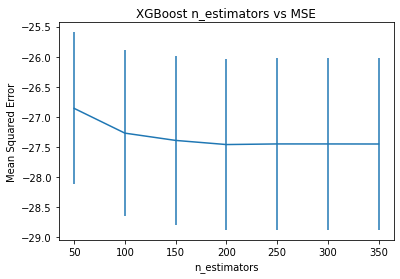

In [99]:
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs MSE")
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()